<a href="https://colab.research.google.com/github/abroniewski/Child-Wasting-Prediction/blob/main/notebooks/acled/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook presents the data cleaning process for Acled data and prevalence data. 

Authors: Luiz Fonseca & Zyrako Musaj

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

## Acled data

In [ ]:
acled_data_path = "https://raw.githubusercontent.com/abroniewski/Child-Wasting-Prediction/main/data/raw/1900-01-01-2022-09-27-Eastern_Africa-Somalia.csv"

acled_df = pd.read_csv(acled_data_path)
acled_df.head(1)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,9499027,706,SOM38074,38074,23 September 2022,2022,1,Explosions/Remote violence,Shelling/artillery/missile attack,Al Shabaab,...,Abdale Birole,-0.4906,42.1969,1,Calamada; Al Furqaan,National,"On 23 September 2022, Al Shabaab militants fir...",0,1664231916,SOM


### Outliers


In [ ]:
#Plotting a map to check for geographical outliers
fig = px.scatter_geo(acled_df,lat='latitude',lon='longitude')
fig.update_layout(title = 'Conflict data of Somalia - 1997-2022', title_x=1)
fig.show()

From the map above we can see that there are no geographical outliers

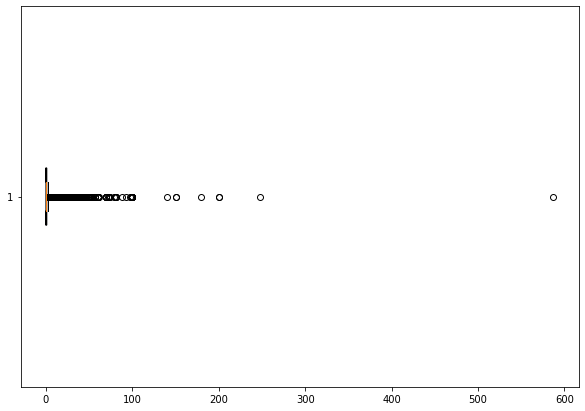

In [ ]:
#Looking for outliers in fatalities
value=acled_df['fatalities']
fig = plt.figure(figsize =(10, 7))

plt.boxplot(value, patch_artist = True, notch ='True', vert = 0)
plt.show()

Since the majority(58%) of the values in fatalities are 0, the values of the boxplot are concentrated to the left. According to the documentation of the dataset, if there is no reference made to fatalities in the report, or if it is unclear whether fatalities occurred at all, “0” fatalities are recorded.

Investigating three of the outermost outliers, which result to be accurate number:

Fatalities=587 is an accurate number (source: https://en.wikipedia.org/wiki/14_October_2017_Mogadishu_bombings)

Fatalities=284 (source: https://www.bbc.com/news/world-africa-36487435)

Fatalities=284 (source: https://en.wikipedia.org/wiki/March_2022_Somalia_attacks)

### Handling missing values

Based on the profiling, these are the columns with considerable number of missing values.

```
assoc_actor_1 has 35019 (92.7%) missing values	
actor2 has 2913 (7.7%) missing values	
assoc_actor_2 has 32049 (84.8%) missing values	
admin3 has 37782 (100.0%) missing values 
notes has 1725 (4.6%) missing
```
Based on the description of the columns, it makes sense that they have missing values. There's no need to imput those values. The columns admin3,  will be dropped since all the values are missing.

The columns assoc_actor_1 and assoc_actor_2 will be kept even though they have a lot of missing values. These columns can be used to know which actors are helping the main actors. It's an interesting analysis.


In [ ]:
#Drop columns not needed
df_clean = acled_df.drop(labels=['data_id','iso','event_id_cnty','event_id_no_cnty','time_precision', 'region', 'country', 'admin3','geo_precision','iso3'],axis=1)

#Change date format
df_clean['event_date'] = pd.to_datetime(df_clean['event_date'])

In [ ]:
acled_df = df_clean
acled_df.head(1)

,event_date,year,event_type,sub_event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,...,admin1,admin2,location,latitude,longitude,source,source_scale,notes,fatalities,timestamp
0,2022-09-23,2022,Explosions/Remote violence,Shelling/artillery/missile attack,Al Shabaab,NaN,2,ATMIS: African Union Transition Mission in Som...,NaN,8,...,Lower Juba,Kismaayo,Abdale Birole,-0.4906,42.1969,Calamada; Al Furqaan,National,"On 23 September 2022, Al Shabaab militants fir...",0,1664231916


## Prevalence data

In [ ]:
prevalence_data_path = "https://raw.githubusercontent.com/abroniewski/Child-Wasting-Prediction/main/data/ZHL/prevalence_estimates.csv"
prevalence_df = pd.read_csv(prevalence_data_path, parse_dates=['date']).iloc[:, 1:]  # Drop first column that is just row numbers
prevalence_df.head(5)

,date,district,total population,Under-Five Population,GAM,MAM,SAM,GAM Prevalence,SAM Prevalence,SAM/GAM ratio
0,2021-07-01,Adan Yabaal,NaN,17190.0,4930.0,NaN,710.0,0.286795,0.041303,0.144016
1,2021-07-01,Afgooye,NaN,94444.6,43800.0,NaN,8930.0,0.463764,0.094553,0.203881
2,2021-07-01,Afmadow,NaN,46703.8,18290.0,NaN,4150.0,0.391617,0.088858,0.226900
3,2021-07-01,Baardheere,NaN,34453.4,13330.0,NaN,2230.0,0.386899,0.064725,0.167292
4,2021-07-01,Badhaadhe,NaN,14272.6,5790.0,NaN,1330.0,0.405672,0.093186,0.229706


### Handling missing values

Based on the previous data quality check, the columns with missing values are:

```
total population has 74 (10.9%) missing values
MAM has 148 (21.9%) missing values
```

We should not worry about MAM since the main indicator is GAM. \
Let's dive deep into population to see if can input the value

In [ ]:
# Check which districts have a null value in "total population".
prevalence_df[prevalence_df['total population'].isnull()].district.unique()

array(['Adan Yabaal', 'Afgooye', 'Afmadow', 'Baardheere', 'Badhaadhe',
       'Baidoa', 'Baki', 'Balcad', 'Banadir', 'Bandarbeyla', 'Baraawe',
       'Belet Weyne', 'Belet Xaawo', 'Berbera', 'Borama', 'Bossaso',
       "Bu'aale", 'Bulo Burto', 'Burco', 'Burtinle', 'Buuhoodle',
       'Buur Hakaba', 'Cabudwaaq', 'Cadaado', 'Cadale', 'Caluula',
       'Caynabo', 'Ceel Afweyn', 'Ceel Barde', 'Ceel Buur', 'Ceel Dheer',
       'Ceel Waaq', 'Ceerigaabo', 'Dhuusamarreeb', 'Diinsoor', 'Doolow',
       'Eyl', 'Gaalkacyo', 'Galdogob', 'Garbahaarey', 'Garoowe',
       'Gebiley', 'Hargeysa', 'Hobyo', 'Iskushuban', 'Jalalaqsi',
       'Jamaame', 'Jariiban', 'Jilib', 'Jowhar', 'Kismaayo',
       'Kurtunwaarey', 'Laas Caanood', 'Laasqoray/Badhan', 'Lughaye',
       'Luuq', 'Marka', 'Owdweyne', 'Qandala', 'Qansax Dheere', 'Qardho',
       'Qoryooley', 'Rab Dhuure', 'Saakow/Salagle', 'Sablaale', 'Sheikh',
       'Taleex', 'Tayeeglow', 'Waajid', 'Wanla Weyn', 'Xarardheere',
       'Xudun', 'Xudur', 'Zey

Many districts have at least 1 null value in the column "total population", which discards the possibility of this being an issue of just some districts. Let's check if it is an issue with the date of the collection.

In [ ]:
prevalence_df[prevalence_df['total population'].isnull()].date.unique()

array(['2021-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

Only for data collected in 2021-07-01, which is the last month of collected data, the total population is missing. We can just input the population based on the previous month under the assumption that the population would not change drastically from one month to another.

However the inputation should be done by the person doing further analysis in a way that this process wouldn't interfere with the analisys. 

### Handling outliers

First, let's see the distribution of each variable in the boxplots below.

In [ ]:
px.box(prevalence_df, y=['total population',	'Under-Five Population']).show()

In [ ]:
px.box(prevalence_df, y=['GAM', 'MAM', 'SAM']).show()

In [ ]:
px.box(prevalence_df, y=['GAM Prevalence', 'SAM Prevalence',	'SAM/GAM ratio']).show() 

It seems that some variables have extreme positive values. Let's start by analyzing the districts that have extreme values for total population. It is expected that a higher population drags other variables up.

The Q3 for total population is 180251. Let's see which districts have a population value higher than this.

In [ ]:
prevalence_df[prevalence_df['total population'] > 180251]['district'].unique()

array(['Borama', 'Hargeysa', 'Burco', 'Laas Caanood', 'Ceerigaabo',
       'Laasqoray/Badhan', 'Bossaso', 'Garoowe', 'Gaalkacyo',
       'Belet Weyne', 'Balcad', 'Afgooye', 'Kurtunwaarey', 'Marka',
       'Qoryooley', 'Baydhaba/Bardaale', 'Banadir', 'Kismaayo',
       'Baydhaba', 'Baidoa', 'Laasqoray', 'Afmadow/Xagar', 'Jowhar',
       'Bulo Burto', 'Wanla Weyn', 'Xarardheere', 'Mogadishu', 'Burao',
       'Hobyo', 'Qardho'], dtype=object)

Several districts would happen to have outliers in the population. Let's see if the measurements of population are constant for all the dates.

In [ ]:
px.line(prevalence_df, x="date", y="total population", color='district').show()

Apparently, not all districts have data collected in all available dates.

How to explain the sundden population growth in Banaadir from Jul 2019 to Jan 2020?

By doing some research I've found [this report](https://documents1.worldbank.org/curated/en/764681585029507635/pdf/Somalia-2019-Floods-Impact-and-Needs-Assessment.pdf) entitled "SOMALIA
2019 FLOODS IMPACT AND NEEDS ASSESSMENT". On page 47 there's a table showing that Banadir's population went from 1.6 million in 2014 to 2.1 million in 2019, which is aproximated to the numbers we see in the chart above, but not to the dates. Since we don't know when the population census was collected, we just assume that before july 2019 the source of this data was still using the total population computed in 2014 and after july 2019 the new number is being used.

So far, I decided to not remove any measurement for total population. But The insights showed here are already valuable for someone else working with this data to dive deeper into this matter and decide what to do with it. 






In [ ]:
px.line(prevalence_df, x="date", y="Under-Five Population", color='district').show()

As expected, the districts with higher population are also the districts with higher number of children under 5. So, not much to investigate here. The population is the main variable to search for outliers since the other variables are expected to be a reflex of the total population.

## Saving transformations

In [ ]:
from pathlib import Path  

prevalence_filepath = Path('/content/drive/MyDrive/Data Challenge 3/Data/prevalence_estimates.csv')  
prevalence_filepath.parent.mkdir(parents=True, exist_ok=True)  
prevalence_df.to_csv(prevalence_filepath, index=False)

compression_opts = dict(method='zip', archive_name='acled.csv') 
acled_df.to_csv('/content/drive/MyDrive/Data Challenge 3/Data/acled.zip', index=False, compression=compression_opts)